## Environment Preparation

Before starting, an interesting function `plot_model` was used in the class's [sample code for AEs](https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter3-autoencoders/autoencoder-mnist-3.2.1.py). In Google Colab, the dependencies of the function do not seem to be natively supported. However, there are ways to install it. This makes use of the method outlined in [Plot Keras Model in Colab Error Reproduced.ipynb](https://colab.research.google.com/drive/1n2HJw3zcZRqWdbXPwC_lkajJ7XRgquFC#scrollTo=8eG45JeqXNlm).

For the submission, this was hidden (in case it's already used in Jupyter).

In [1]:
!apt install python-pydot python-pydot-ng graphviz
# Unfortunately the installed packages tie to Python 2 instead of Python 3
!echo "Check with Python 2"
!python2.7 -c "import pydot"
!echo "Check with Python 3"
!python -c "import pydot"

!pip -V
!dot -V
!pip install pydot pydot-ng
!echo "Check again with Python 3"
!python -c "import pydot"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
python-pydot is already the newest version (1.2.3-1).
python-pydot-ng is already the newest version (1.0.0-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Check with Python 2
Check with Python 3
pip 19.3.1 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)
dot - graphviz version 2.40.1 (20161225.0304)
Check again with Python 3


# Unsupervised MNIST Classifier

Create an MNIST classifier using the encoder part of a trained auto-encoder. Cluster feature vectors using K-means, and assign labels to each cluster using the Hungarian Algorithm.

In [2]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers, initializers

## Dataset Preparation

Check out the test data that will be used to verify the model's performance. In this case, the first 8 items of `x_test` are used.

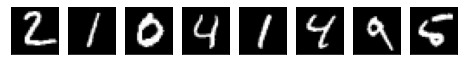

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
n = 8
plt.figure(figsize=(8, 1))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train = x_train.astype(np.float32) / 255
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_test = x_test.astype(np.float32) / 255

## Autoencoder

`epochs` was set to 50 originally, but 10 also seemed like a fairly reasonable number of epochs to have considering also the changes from other parameters.

The `latent_dim` was set to the number of MNIST classes. This is so that the features of the images can be compressed into 10 float numbers.

In [5]:
input_shape = (image_size, image_size, 1)
epochs = 10
batch_size = 64
kernel_size = 3
latent_dim = 10
layer_filters = [16, 64]

In [6]:
inputs = Input(shape=input_shape, name='encoder_in')
x = inputs

for idx, filters in enumerate(layer_filters):
  x = Conv2D(filters=filters,
             kernel_size=kernel_size,
             activation='relu',
             strides=2,
             padding='same')(x)

shape = K.int_shape(x)

x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder')
encoder.summary()
# plot_model(encoder, to_file='encoder.png', show_shapes=True)

latent_inputs = Input(shape=(latent_dim,), name='decoder_in')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for idx, filters in enumerate(layer_filters[::-1]):
  x = Conv2DTranspose(filters=filters,
             kernel_size=kernel_size,
             activation='relu',
             strides=2,
             padding='same')(x)

outputs = Conv2DTranspose(filters=1,
                 kernel_size=kernel_size,
                 activation='sigmoid',
                 padding='same',
                 name='decoder_out')(x)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# plot_model(decoder, to_file='decoder.png', show_shapes=True)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_in (InputLayer)      [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          9280      
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 10)                31370     
Total params: 40,810
Trainable params: 40,810
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Sh

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_in (InputLayer)      [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 10)                40810     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         80801     
Total params: 121,611
Trainable params: 121,611
Non-trainable params: 0
_________________________________________________________________


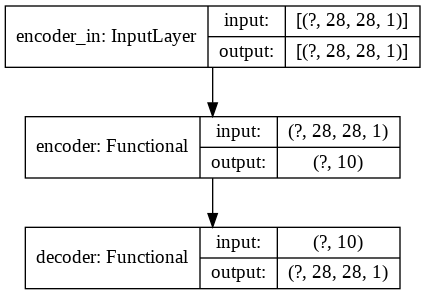

In [7]:
autoencoder = Model(inputs,
                    decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

Initially used `binary_crossentropy` for the loss, but it seems to converge faster with `mse`, though it also takes longer to train. Also noting that it seems to converge faster with lower valued to higher valued filter sizes than higher to lower valued.

In [8]:
autoencoder.compile(loss='mse', optimizer='adam')

In [9]:
history = autoencoder.fit(x_train, x_train,
                          validation_data=(x_test, x_test),
                          epochs=epochs,
                          batch_size=batch_size)

Epoch 1/10
938/938 [==============================] - 68s 73ms/step - loss: 0.0360 - val_loss: 0.0189
Epoch 2/10
938/938 [==============================] - 69s 73ms/step - loss: 0.0175 - val_loss: 0.0162
Epoch 3/10
938/938 [==============================] - 69s 74ms/step - loss: 0.0157 - val_loss: 0.0149
Epoch 4/10
938/938 [==============================] - 69s 73ms/step - loss: 0.0148 - val_loss: 0.0143
Epoch 5/10
938/938 [==============================] - 69s 74ms/step - loss: 0.0142 - val_loss: 0.0138
Epoch 6/10
938/938 [==============================] - 69s 74ms/step - loss: 0.0138 - val_loss: 0.0134
Epoch 7/10
938/938 [==============================] - 70s 74ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 8/10
938/938 [==============================] - 69s 74ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 9/10
938/938 [==============================] - 69s 74ms/step - loss: 0.0130 - val_loss: 0.0129
Epoch 10/10
938/938 [==============================] - 69s 74ms/step - loss: 0.012

This compares the input test set `x_test` with predictions on it that are stored in `x_decoded`.

In [10]:
x_decoded = autoencoder.predict(x_test)
test_accuracy = np.mean(np.equal(x_test, np.round(x_decoded)))
print(f"Test Accuracy: {test_accuracy * 100.0}%")
# 81.1058%

Test Accuracy: 81.15188775510204%


A visual inspection of how the model performs on the test set.

It seems to represent the digit fairly even if the latent dimension is low.

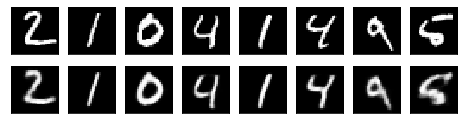

In [11]:
n = 8
plt.figure(figsize=(8, 2))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28),
               cmap="gray",
               interpolation="none")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_decoded[i].reshape(28, 28),
               cmap="gray",
               interpolation="none")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Note that the autoencoder has this structure (as can be viewed in `autoencoder.summary()`: encoder_input -> encoder_output/decoder_input -> decoder_output.

From there, the encoder can be extracted by taking the second to the last output layer. Layers are counted from the last of the array to make it clearer that it refers to the output.

The original `encoder` variable could also be called, but this way of extracting the encoder from AE seemed a bit more clear. To check if it matches the size of the `encoder` model, `trained_encoder.summary()` is called.

In [12]:
trained_encoder = Model(autoencoder.input, autoencoder.layers[-2].output)
trained_encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_in (InputLayer)      [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          9280      
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 10)                31370     
Total params: 40,810
Trainable params: 40,810
Non-trainable params: 0
_________________________________________________________________


Below seems like a nice visualization of the data so far. The idea came from [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html).

In this segment, `x_train` encoded representations are acquired. These will be used in for K-Means.

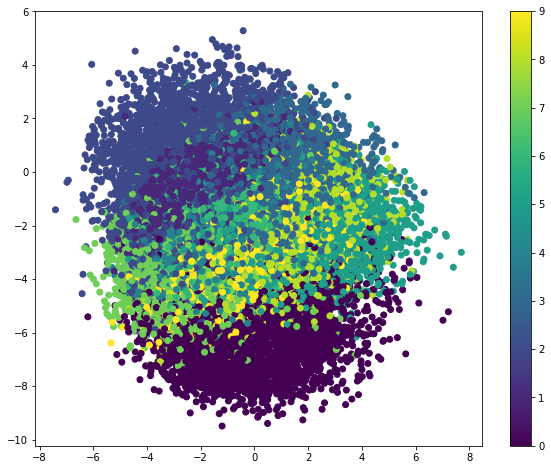

In [13]:
x_encoded_train = trained_encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(10, 8))
plt.scatter(x_encoded_train[:, 0], x_encoded_train[:, 1], c=y_train, cmap="viridis")
plt.colorbar()
plt.show()

## K-Means

The K-Means part makes use of `sklearn.cluster.KMeans`

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import completeness_score

`n_clusters` is set to the number of classes in MNIST.

In [15]:
cluster = KMeans(n_clusters=10,
                 n_init=60,
                 tol=1e-6,
                 random_state=0,
                 max_iter=1000)

K-Means takes in input that has 2 or less dimensions. This is why reshaping is used on `x_encoded_train`.

In [16]:
cluster_x_train = x_encoded_train.reshape((x_encoded_train.shape[0], -1))
hist_kmeans = cluster.fit(cluster_x_train)

`completeness_score` seems to be a good metric for the clustering. It provides a number that represents how many of the similar labels are in the same cluster.

In [17]:
x_encoded_train = trained_encoder.predict(x_train, batch_size=batch_size)
cluster_x_train = x_encoded_train.reshape((x_encoded_train.shape[0], -1))
x_clustered_train = cluster.predict(cluster_x_train)
k_train_accuracy = completeness_score(x_clustered_train, y_train)
print(f"Train Accuracy: {k_train_accuracy * 100.0}%")

x_encoded_test = trained_encoder.predict(x_test, batch_size=batch_size)
cluster_x_test = x_encoded_test.reshape((x_encoded_test.shape[0], -1))
x_clustered_test = cluster.predict(cluster_x_test)
k_test_accuracy = completeness_score(x_clustered_test, y_test)
print(f"Test Accuracy: {k_test_accuracy * 100.0}%")

Train Accuracy: 68.00190709028732%
Test Accuracy: 70.4032750836931%


This is a more visual check of how K-Means fares on the test set.

From below, it seems that it doesn't distinguish too well between 4 and 9.

In [18]:
n = 10
print(f"x_test:\t\t\t {y_test[:n]}")
print(f"clustered x_test:\t {x_clustered_test[:n]}")

x_test:			 [7 2 1 0 4 1 4 9 5 9]
clustered x_test:	 [4 0 7 6 1 7 1 1 1 9]


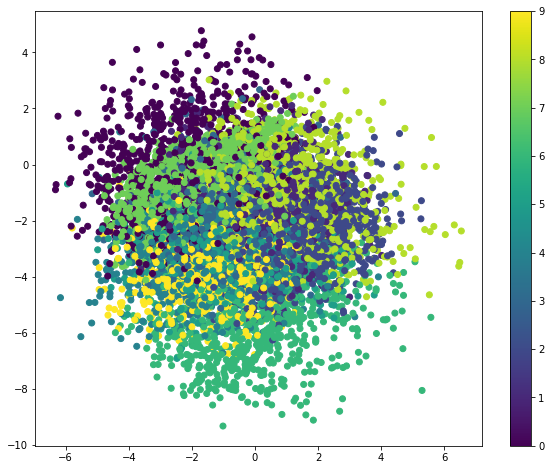

In [19]:
plt.figure(figsize=(10, 8))
plt.scatter(cluster_x_test[:, 0],
            cluster_x_test[:, 1],
            c=x_clustered_test,
            cmap="viridis")
plt.colorbar()
plt.show()

## Hungarian Algorithm

In the K-Means section, the image feature vectors were clustered with similar feature vectors. However, these are still differently labeled.

In implementing this part, `scipy.optimize.linear_sum_assignment` was used. In the backend, it seems runs using the Hungarian Algorithm.

In [20]:
from scipy.optimize import linear_sum_assignment

In [21]:
D = max(x_clustered_test.max(), y_test.max()) + 1
w = np.zeros((D, D), dtype=np.int64)

for i in range(x_clustered_test.size):
  w[x_clustered_test[i], y_test[i]] += 1

gt_ind, cluster_ind = linear_sum_assignment(w.max() - w)
print(f"Digits: \t{gt_ind}")
print(f"Cluster: \t{cluster_ind}")

Digits: 	[0 1 2 3 4 5 6 7 8 9]
Cluster: 	[2 4 8 6 7 5 0 1 3 9]


From the result of matching the digits with the clusters, the following mapping is produced:

Ground Truth Label | Cluster
:---: | :---:
0 | 2
1 | 4
2 | 8
3 | 6
4 | 7
5 | 5
6 | 0
7 | 1
8 | 3
9 | 9

Another way of checking out the labels is by using a confusion matrix. This is shown below.

Note that `seaborn` is used as its plotting of the confusion matrix is better than that of `matplotlib` (by way of `plt.matshow()`)

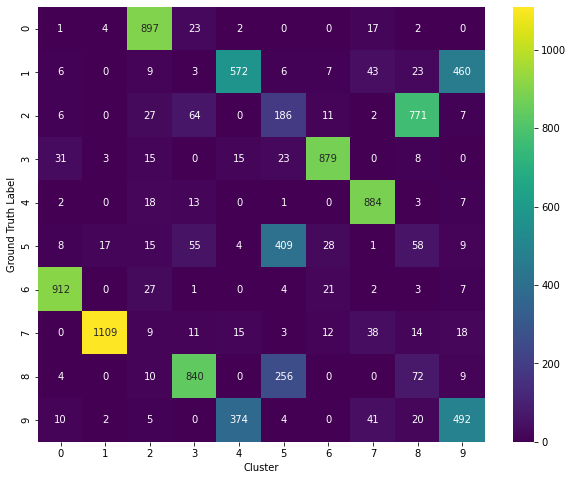

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

conf_mat = confusion_matrix(x_clustered_test, y_test)

plt.figure(figsize=(10, 8))
sn.heatmap(conf_mat,
           annot=True,
           annot_kws={"size": 10},
           fmt="d",
           cmap="viridis")
plt.xlabel("Cluster")
plt.ylabel("Ground Truth Label")
plt.show()

The confusion matrix provides some insight regarding how the labels and their corresponding clusters were acquired, and how the model has performed in its classifying task.

From here, it can also be observed that the model has a tendency to mix up 1 and 9. It is also fairly confident in its classification of 0, 3, 4, 6 and 7.
